In [1]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 读取GeoJSON文件
gdf = gpd.read_file("C:\\Users\\28578\\Desktop\\2025赛题\\Bus_Routes.geojson")

# 获取所有公交线路名称
route_names = gdf['Route_Name'].unique()

# 为每条公交线路分配一个颜色
colors = list(mcolors.TABLEAU_COLORS.values())  # 使用Tableau颜色
route_color_map = {route: colors[i % len(colors)] for i, route in enumerate(route_names)}

cf = '["highway"~"motorway|primary|secondary|tertiary"]'
#G57 = ox.graph.graph_from_place(place5_around, network_type="drive", custom_filter=cf7)
map_graph = ox.graph.graph_from_place("Baltimore, Maryland, USA", network_type="drive", custom_filter=cf)

In [17]:
import networkx as nx

G = nx.G = nx.MultiDiGraph()
node_id = 0
coord_to_id = {}  # 用于映射坐标到唯一节点ID

for idx, row in gdf.iterrows():
    geometry = row.geometry
    if geometry.geom_type == 'MultiLineString':
        for line in geometry.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                start_coord = coords[i]
                end_coord = coords[i+1]
                
                # 处理起点坐标
                if start_coord not in coord_to_id:
                    G.add_node(node_id, x=start_coord[0], y=start_coord[1])
                    coord_to_id[start_coord] = node_id
                    node_id += 1
                start_id = coord_to_id[start_coord]
                
                # 处理终点坐标
                if end_coord not in coord_to_id:
                    G.add_node(node_id, x=end_coord[0], y=end_coord[1])
                    coord_to_id[end_coord] = node_id
                    node_id += 1
                end_id = coord_to_id[end_coord]
                
                # 添加边
                G.add_edge(start_id, end_id, key=0, route=row['Route_Name'])

# 确保设置坐标系
G.graph["crs"] = "epsg:4326"



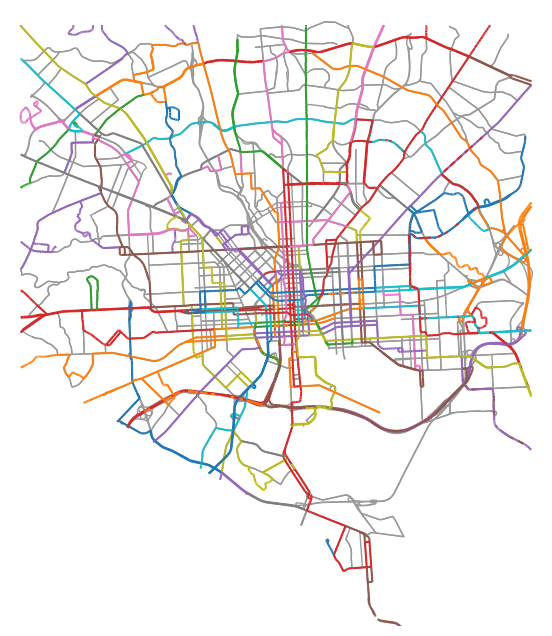

In [3]:
# 提取所有节点的经纬度
node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# 绘制地图底图
fig, ax = ox.plot_graph(map_graph, node_size = 0, bgcolor='white',show=False, close=False )

# 绘制公交路线，每条路线使用不同的颜色
edge_colors = [route_color_map[G.edges[edge]['route']] for edge in G.edges()]
nx.draw(G, pos=node_positions, ax=ax, node_size=0, edge_color=edge_colors, width=1.5)

plt.show()

In [18]:
import pandas as pd

# 读取公交站点数据
bus_stops = pd.read_csv("C:\\Users\\28578\\Desktop\\2025赛题\\2025_Problem_D_Data\\Bus_Stops.csv")
# 提取需要的列（经纬度和吞吐量）
bus_stops = bus_stops[['Y', 'X', 'Stop_Rider']]
# 重命名列以符合osmnx的坐标格式
bus_stops = bus_stops.rename(columns={'Y': 'lat', 'X': 'lon', 'Stop_Rider': 'throughput'})

# 在创建图 G 后，显式设置坐标系（假设原始数据是WGS84）
G.graph["crs"] = "epsg:4326"  # 添加这一行


In [19]:
from shapely.geometry import Point

# 为每个公交站点创建Point对象
bus_stops['geometry'] = bus_stops.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# 将站点匹配到最近的网络节点
for _, stop in bus_stops.iterrows():
    # 找到最近的节点
    nearest_node = ox.distance.nearest_nodes(G, stop['lon'], stop['lat'])
    
    # 累加吞吐量（如果多个站点对应同一节点）
    if 'throughput' in G.nodes[nearest_node]:
        G.nodes[nearest_node]['throughput'] += stop['throughput']
    else:
        G.nodes[nearest_node]['throughput'] = stop['throughput']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# 提取吞吐量数据并归一化
throughputs = [data['throughput'] for _, data in G.nodes(data=True) if 'throughput' in data]
min_thru, max_thru = min(throughputs), max(throughputs)

# 创建颜色映射和大小映射
norm = Normalize(vmin=min_thru, vmax=max_thru)
cmap = plt.cm.plasma

nc = []
ns = []
size_range = (10, 100)  # 节点大小范围

for _, data in G.nodes(data=True):
    if 'throughput' in data:
        # 颜色基于归一化后的吞吐量
        nc.append(cmap(1.573*norm(data['throughput'])))
        # 大小基于线性缩放
        size = (data['throughput'] - min_thru)/(max_thru - min_thru)*(size_range[1]-size_range[0]) + size_range[0]
        ns.append(size)
    else:
        nc.append('gray')
        ns.append(0)

# 绘制图形
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(
    G,
    ax=ax,
    node_color=nc,
    node_size=ns,
    edge_linewidth=0.5,
    edge_color='#999999',
    bgcolor='white',
    show=False,  # 禁止自动调用 plt.show()
    close=False   # 禁止自动关闭图形
)

# 添加颜色条（关键修改）
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(throughputs)  # 直接关联原始数据
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label('Passenger Throughput', fontsize=12)

plt.title('Baltimore Bus Network with Passenger Throughput')
plt.show()

### 计算线路客流量

In [54]:
# 计算每条线路的平均客流量（总客流量/线路节点数）
route_nodes = {}
for u, v, key, data in G.edges(keys=True, data=True):
    route = data['route']
    route_nodes.setdefault(route, set()).update({u, v})

route_throughput = {
    route: sum(G.nodes[node].get('throughput', 0) for node in nodes) / max(1, len(nodes))  # 避免除以零
    for route, nodes in route_nodes.items()
}



In [55]:

# 按客流量降序排序线路
sorted_routes = sorted(route_throughput.items(), key=lambda x: -x[1])
total_routes = len(sorted_routes)

# 初始化分组
groups = []
if total_routes > 0:
    # 前6名为第一组
    groups.append(sorted_routes[:6])
    remaining = sorted_routes[6:]
    if remaining:
        # 将剩余线路均分到6个组
        num_groups = 6
        group_size = len(remaining) // num_groups
        remainder = len(remaining) % num_groups
        current = 0
        for i in range(num_groups):
            size = group_size + (1 if i < remainder else 0)
            groups.append(remaining[current:current+size])
            current += size
    else:
        # 补充空组
        groups.extend([[]]*6)
else:
    groups = [[] for _ in range(7)]

In [56]:

# 生成7个等间距的Plasma颜色（从亮到暗）
cmap = plt.cm.plasma
color_levels = [1.0 - i*(1.0/6) for i in range(7)]  # 7个颜色值

# 创建路由到颜色的映射
route_color_map = {}
for level_idx in range(7):
    if level_idx >= len(groups):
        break
    for route, _ in groups[level_idx]:
        route_color_map[route] = cmap(color_levels[level_idx])

In [57]:

# # 生成颜色映射（移除乘数2的缩放）
# throughput_values = list(route_throughput.values())
# norm = mcolors.Normalize(vmin=min(throughput_values), vmax=max(throughput_values))
# cmap = plt.cm.plasma
# route_color_map = {route: cmap(norm(throughput)) for route, throughput in route_throughput.items()}  # 直接使用throughput

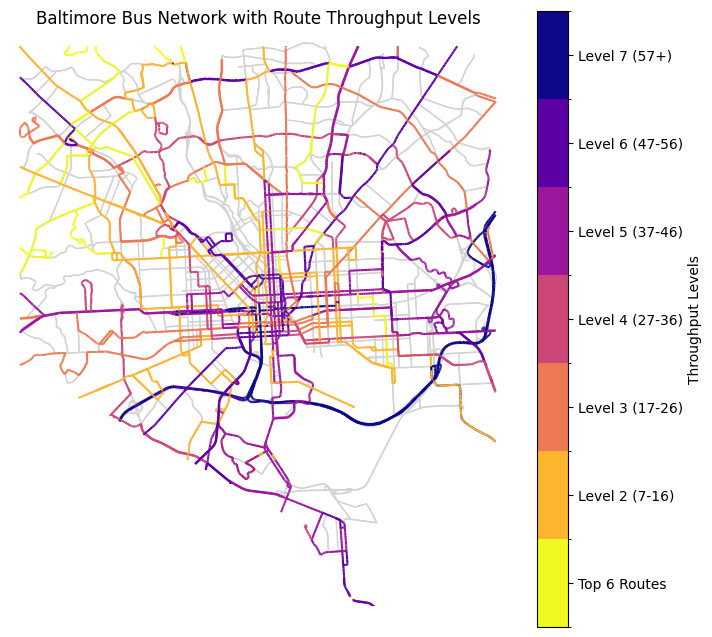

In [58]:
# 绘制底图
fig, ax = ox.plot_graph(
    map_graph, 
    node_size=0, 
    bgcolor='white',
    edge_color='lightgray',
    show=False,
    close=False
)
ax.set_facecolor('white')

# 生成边颜色列表
edge_colors = [
    route_color_map.get(data['route'], 'lightgray')  # 默认颜色
    for u, v, key, data in G.edges(keys=True, data=True)
]

# 绘制公交线路
nx.draw(
    G, 
    pos=node_positions, 
    ax=ax, 
    node_size=0, 
    edge_color=edge_colors, 
    width=1.5, 
    arrows=False
)

# 创建离散颜色条
from matplotlib.colors import ListedColormap, BoundaryNorm

# 定义颜色等级描述
color_descriptions = [
    'Top 6 Routes',
    'Level 2 (7-16)',
    'Level 3 (17-26)',
    'Level 4 (27-36)',
    'Level 5 (37-46)',
    'Level 6 (47-56)',
    'Level 7 (57+)'
]

# 创建自定义颜色条
discrete_cmap = ListedColormap([cmap(lvl) for lvl in color_levels], name='Discrete Plasma')
norm = BoundaryNorm([i-0.5 for i in range(8)], discrete_cmap.N)  # 中心对齐刻度

sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# 添加颜色条
cbar = plt.colorbar(sm, ax=ax, 
                    boundaries=[i-0.5 for i in range(8)], 
                    ticks=range(7),
                    spacing='proportional')
cbar.set_label('Throughput Levels')
cbar.ax.set_yticklabels(color_descriptions)

plt.title('Baltimore Bus Network with Route Throughput Levels')
plt.show()